In [327]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [328]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [329]:
x_train

array([[-6.84465022e-01,  1.32517219e+00],
       [-1.98445348e-01, -9.27790789e-02],
       [ 4.59784736e+00,  1.78898202e+00],
       [ 3.39939761e+00,  1.43201360e+00],
       [-2.51583017e+00, -1.88517978e+00],
       [ 2.36588845e-02, -2.66367616e+00],
       [-3.11479259e+00,  2.97054730e+00],
       [-2.42834197e+00,  1.59865677e+00],
       [-1.44120871e-01, -4.55648668e+00],
       [ 2.85840388e+00,  9.18359952e-01],
       [ 8.37097914e-01, -4.16709381e+00],
       [-1.84310092e+00, -1.00459429e+00],
       [-9.34182623e-01, -4.27801193e+00],
       [-8.58845381e-01,  4.20219494e+00],
       [ 1.85692373e+00, -4.28907819e-01],
       [ 3.00317572e+00,  3.35244255e+00],
       [ 3.01628383e-01, -2.35408597e+00],
       [ 1.72900000e+00,  1.92147255e+00],
       [ 3.14836589e+00, -1.28913182e+00],
       [-2.66290832e+00, -2.75984284e+00],
       [ 1.60576040e+00, -3.71318488e+00],
       [ 2.11495144e+00, -1.48920771e-01],
       [-1.00186033e+00,  1.26126302e+00],
       [ 4.

In [330]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [331]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    entropy = 0
    for k in np.unique(label_array):
        pmk = (sum(np.equal(k, label_array).astype(int)) / label_array.shape[0])[0]
        entropy += pmk * np.log(pmk)
   
    return -entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    gini = 0
    for k in np.unique(label_array):
        pmk = (sum(np.equal(k, label_array).astype(int)) / label_array.shape[0])[0]
        gini += pmk * (1 - pmk)
   
    return gini

In [31]:
print(compute_entropy(y_train_label))
print(compute_gini(y_train_label))

0.5510799280869728
0.3648


In [375]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10, force_split=False):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        :param force_split: force skip even if a splitting loss is higher than current loss
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False
        self.force_split = force_split
        '''
        The following fields are added by author
        '''
        
    '''
    Author note: in my algorithm, I forces the node to split (except depth or 
    min_sample criteria is met) even if the split will result in higher loss.
    '''
    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # Corner case: reaches max_depth OR does not meet min_sample to split.
        if self.depth == self.max_depth or len(y) <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        self.split_id, self.split_value, split_pos, best_loss = self.find_best_feature_split(x, y)
        
        if self.force_split or best_loss < self.split_loss_function(y): # split
            # find left and right x, y
            lx, ly, rx, ry = None, None, None, None
            D = np.concatenate([x, y],1) # concatenated dataset for easier sorting
            D = np.array(sorted(D, key=lambda x: x[self.split_id]))
            lx, ly = D[:split_pos+1, :-1], D[:split_pos+1, -1].reshape(-1, 1)
            rx, ry = D[split_pos+1:, :-1], D[split_pos+1:, -1].reshape(-1, 1)

            # initialize left and right node
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                     depth=self.depth+1, min_sample=self.min_sample, max_depth=self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                     depth=self.depth+1, min_sample=self.min_sample, max_depth=self.max_depth)
            self.left.fit(lx, ly)
            self.right.fit(rx, ry)
        else:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        return self

    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (num_samples, num_features)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        split_value, best_loss, best_pos = None, float('inf'), -1
        D = np.concatenate([x_node[:, feature_id].reshape(-1,  1), y_node],1) # concatenated dataset for easier sorting
        D = np.array(sorted(D, key=lambda x: x[0]))
        # iterate through all datapoint intervals
        for pos in range(len(D)-1):
            lx, ly = D[:pos+1, 0], D[:pos+1, 1].reshape(-1, 1)
            rx, ry = D[pos+1:, 0], D[pos+1:, 1].reshape(-1, 1)

            ll = len(ly)*self.split_loss_function(ly)/len(y_node)
            rl = len(ry)*self.split_loss_function(ry)/len(y_node)

            # split condition
            if ll + rl < best_loss:
                split_value = (lx[-1] + rx[0]) / 2
                best_loss = ll + rl
                best_pos = pos
        
        return split_value, best_loss, best_pos

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (num_samples, num_features)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        split_id, split_value, best_loss, best_pos = None, None, float('inf'), -1
        
        for feature_id in range(x_node.shape[1]):
            sv, best_l, pos = self.find_best_split(x_node, y_node, feature_id)
            if best_l < best_loss:
                split_id, split_value, best_pos = feature_id, sv, pos
                best_loss = best_l
        
        return split_id, split_value, best_pos, best_loss

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [350]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [351]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

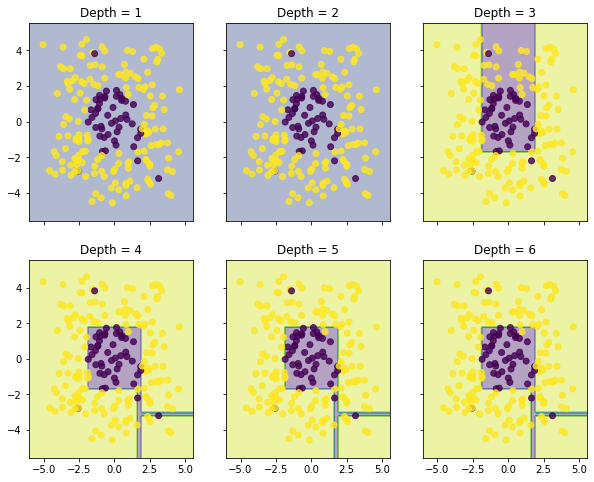

In [372]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.savefig('Q3.png')
plt.show()

# Compare decision tree with tree model in sklearn

In [379]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=2, random_state=1)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

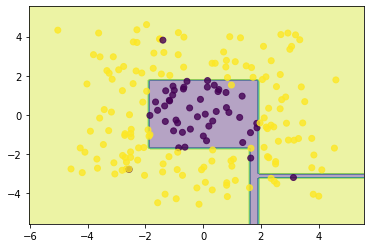

In [380]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

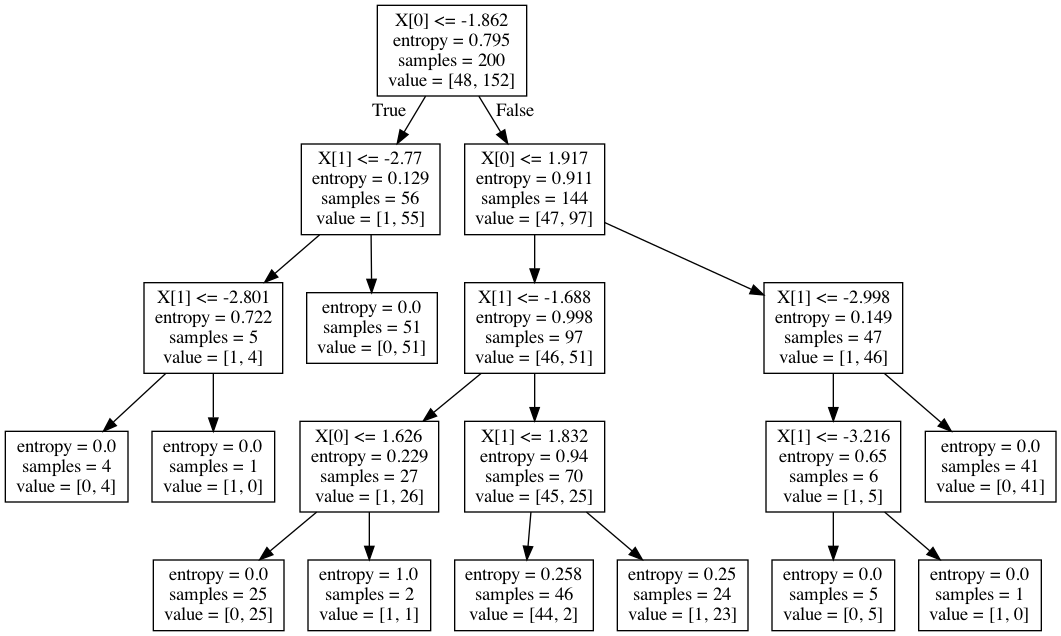

In [369]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [282]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    mae, m = 0, np.mean(y)
    for yi in y:
        mae += np.abs(yi - m)[0]
    
    return mae / len(y)

In [283]:
mean_absolute_deviation_around_median(np.zeros((100, 1)))

0.0

In [284]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

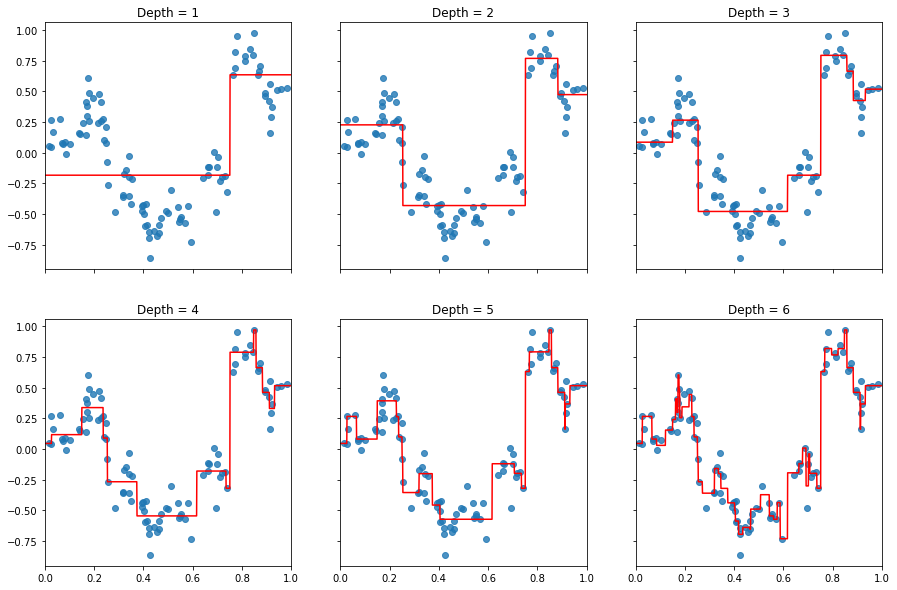

In [301]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.savefig('Q4.png')
plt.show()


# Compare with scikit-learn for debugging

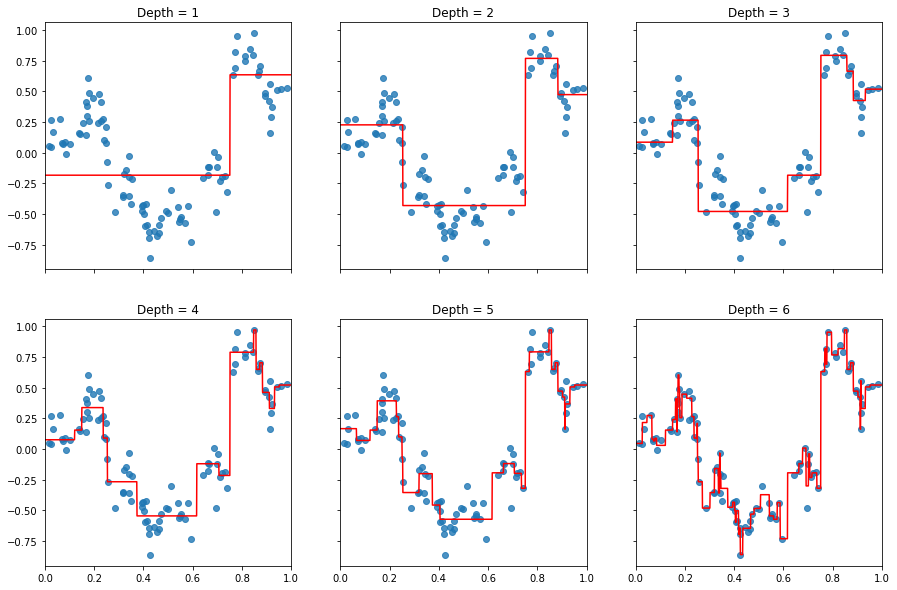

In [287]:
clf_test = DecisionTreeRegressor(criterion='mae', max_depth=2, min_samples_split=3)
clf_test.fit(x_krr_train, y_krr_train)
r1 = clf_test.predict(x_krr_test)

# Training regression trees with different depth
clf1 = DecisionTreeRegressor(criterion='mae', max_depth=1, min_samples_split=3)
clf1.fit(x_krr_train, y_krr_train)

clf2 = DecisionTreeRegressor(criterion='mae', max_depth=2, min_samples_split=3)
clf2.fit(x_krr_train, y_krr_train)

clf3 = DecisionTreeRegressor(criterion='mae', max_depth=3, min_samples_split=3)
clf3.fit(x_krr_train, y_krr_train)

clf4 = DecisionTreeRegressor(criterion='mae', max_depth=4, min_samples_split=3)
clf4.fit(x_krr_train, y_krr_train)

clf5 = DecisionTreeRegressor(criterion='mae', max_depth=5, min_samples_split=3)
clf5.fit(x_krr_train, y_krr_train)

clf6 = DecisionTreeRegressor(criterion='mae', max_depth=10, min_samples_split=3)
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array(clf.predict(x_range))
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [292]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [297]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
        
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # do f0
        res = self.pseudo_residual_func(train_target.reshape(-1), np.zeros(train_target.shape).reshape(-1))
        h0 = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_sample, criterion='mse')
        h0.fit(train_data, res)
        self.estimators.append(h0)
        
        # do f[1, M]
        for m in range(self.n_estimator):
            step = 0
            for i in range(len(self.estimators)):
                step += self.learning_rate * self.estimators[i].predict(train_data)
            
            res = self.pseudo_residual_func(train_target.reshape(-1), step)
            hm = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_sample, criterion='mse')
            hm.fit(train_data, res)
            self.estimators.append(hm)

    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        test_predict = self.learning_rate * sum([estimator.predict(test_data) for estimator in self.estimators])
        
        return test_predict


# 1-D GBM visualization - KRR data

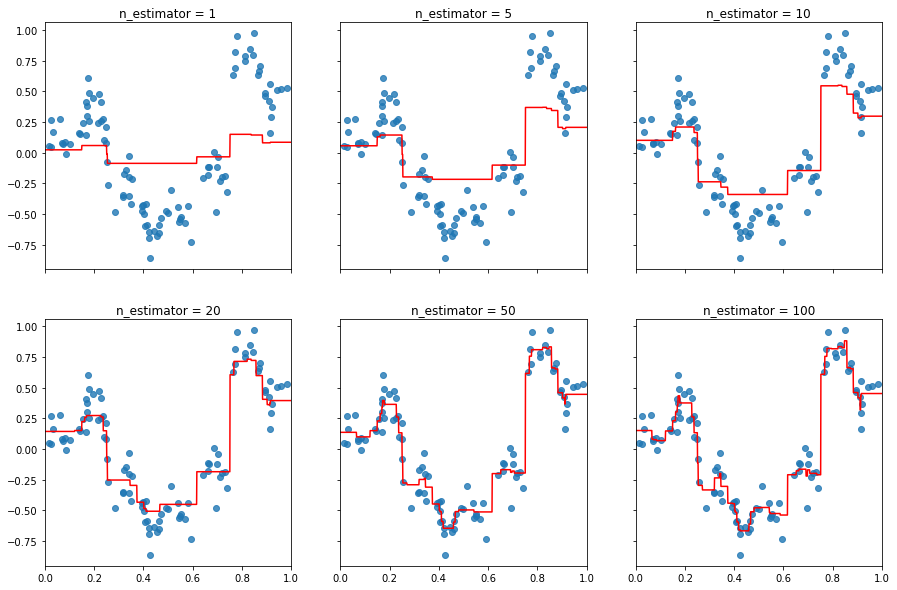

In [299]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

plt.savefig('Q6.png')

# Sklearn implementation for Classification of images

In [302]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


In [303]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1,  
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [381]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

In [385]:
from sklearn.metrics import accuracy_score
train_acc, test_acc = [], []
for n_estimator in [2, 5, 10, 100, 200]:
    clf = GradientBoostingClassifier(loss='deviance', max_depth=3, n_estimators=n_estimator)
    clf.fit(X_train, y_train)
    print('n_estimator: {:3}, Train accuracy: {:15}, test accuracy: {:15}'.format(n_estimator, 
                                                                                  accuracy_score(clf.predict(X_train), y_train), 
                                                                                  accuracy_score(clf.predict(X_test), y_test)))
    train_acc.append(accuracy_score(clf.predict(X_train), y_train))
    test_acc.append(accuracy_score(clf.predict(X_test), y_test))

n_estimator:   2, Train accuracy: 0.9954554635427186, test accuracy: 0.9952849528495284
n_estimator:   5, Train accuracy: 0.9972732781256312, test accuracy: 0.995489954899549
n_estimator:  10, Train accuracy: 0.9972732781256312, test accuracy: 0.9952849528495284
n_estimator: 100, Train accuracy:             1.0, test accuracy: 0.998359983599836
n_estimator: 200, Train accuracy:             1.0, test accuracy: 0.9985649856498565


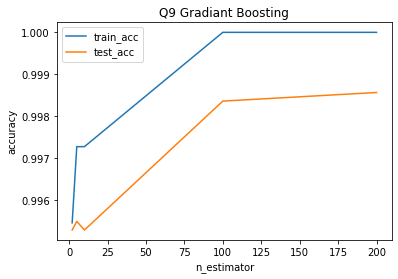

In [395]:
plt.plot([2, 5, 10, 100, 200], train_acc, label='train_acc')
plt.plot([2, 5, 10, 100, 200], test_acc, label='test_acc')
plt.ylabel('accuracy')
plt.xlabel('n_estimator')
plt.title('Q9 Gradiant Boosting')
plt.legend(loc='best')
plt.savefig('Q9.png')
plt.show()

In [397]:
train_acc, test_acc = [], []
for n_estimator in [2, 5, 10, 100, 200]:
    clf = RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=n_estimator)
    clf.fit(X_train, y_train)
    print('n_estimator: {:3}, Train accuracy: {:15}, test accuracy: {:15}'.format(n_estimator,
                                                                                  accuracy_score(clf.predict(X_train), y_train),
                                                                                  accuracy_score(clf.predict(X_test), y_test)))
    train_acc.append(accuracy_score(clf.predict(X_train), y_train))
    test_acc.append(accuracy_score(clf.predict(X_test), y_test))

n_estimator:   2, Train accuracy: 0.9954554635427186, test accuracy: 0.9948749487494875
n_estimator:   5, Train accuracy: 0.9964653605332257, test accuracy: 0.997129971299713
n_estimator:  10, Train accuracy: 0.9970712987275298, test accuracy: 0.997129971299713
n_estimator: 100, Train accuracy: 0.997677236921834, test accuracy: 0.9981549815498155
n_estimator: 200, Train accuracy: 0.9981821854170875, test accuracy: 0.9989749897498975


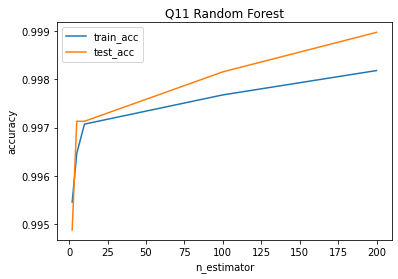

In [398]:
plt.plot([2, 5, 10, 100, 200], train_acc, label='train_acc')
plt.plot([2, 5, 10, 100, 200], test_acc, label='test_acc')
plt.ylabel('accuracy')
plt.xlabel('n_estimator')
plt.title('Q11 Random Forest')
plt.legend(loc='best')
plt.savefig('Q11.png')
plt.show()

In [387]:
for depth in [2, 5, 10, 15, 20]:
    clf = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=10)
    clf.fit(X_train, y_train)
    print('n_estimator: {:3}, Train accuracy: {:15}, test accuracy: {:15}'.format(depth,
                                                                                  accuracy_score(clf.predict(X_train), y_train),
                                                                                  accuracy_score(clf.predict(X_test), y_test)))

n_estimator:   2, Train accuracy: 0.9968693193294283, test accuracy: 0.9977449774497745
n_estimator:   5, Train accuracy: 0.9985861442132903, test accuracy: 0.999179991799918
n_estimator:  10, Train accuracy:             1.0, test accuracy: 0.999589995899959
n_estimator:  15, Train accuracy:             1.0, test accuracy: 0.999179991799918
n_estimator:  20, Train accuracy:             1.0, test accuracy: 0.9993849938499385
